# Chapter 5: Quantum Annealing Strategy

Introduction to quantum annealing using D-Wave systems and QUBO formulations.

---

**Prerequisites:**
- See `Chapter02_QuantumSoftware.ipynb` for installation instructions


In [1]:
# Setup and imports for D-Wave
import numpy as np
import matplotlib.pyplot as plt
import neal
from pyqubo import Binary, Array,Placeholder
from dimod.reference.samplers import ExactSolver
import networkx as nx
import openjij as oj
from dimod import BinaryQuadraticModel
from Chapter03_EngineeringOptimization_functions import (truss2x2,truss2x3,truss3x3,TrussFEM)
from Chapter05_QuantumAnnealing_functions import QATrussOptimizer, print_QUBO_best_result



##  A 3-variable QUBO problem using an exact solver.

$$ \min_{\{a,b,c\}}  (0.6 a b +0.2 a c + 0.03 b c - 0.1 a - 0.5 b - 0.2c ) $$

In [2]:
a,b,c = Binary("a"), Binary("b"),Binary("c")
H  = 0.6*a*b +0.2*a*c + 0.03*b*c -0.1*a - 0.5*b -0.2*c
model = H.compile()
bqm = model.to_bqm()

## Use exact solver

In [3]:
# using exact solver for small problems
exact_sampler = ExactSolver() 
exact_results = exact_sampler.sample(bqm)
print(exact_results)



   a  b  c energy num_oc.
6  0  1  1  -0.67       1
7  0  1  0   -0.5       1
1  0  0  1   -0.2       1
2  1  0  1   -0.1       1
3  1  0  0   -0.1       1
0  0  0  0    0.0       1
4  1  1  0    0.0       1
5  1  1  1   0.03       1
['BINARY', 8 rows, 8 samples, 3 variables]


##  Simulated Annealing

In [4]:
sa_sampler = neal.SimulatedAnnealingSampler()
sa_results = sa_sampler.sample(bqm)
print_QUBO_best_result(sa_results, "SA: ")


SA:  q values: [0, 1, 1]
SA:  Lowest Energy: -0.67


([0, 1, 1], np.float64(-0.6699999999999999))

## Simulated quantum annealing

In [5]:
sqa_sampler = oj.SQASampler()
sqa_results = sqa_sampler.sample(bqm)
print_QUBO_best_result(sqa_results, "SQA: ")

SQA:  q values: [0, 1, 1]
SQA:  Lowest Energy: -0.67


([0, 1, 1], np.float64(-0.6699999999999999))

## Max-cut graph QUBO problem 

In [6]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1

model = H.compile()
bqm = model.to_bqm()
 
exact_results = exact_sampler.sample(bqm)

print_QUBO_best_result(exact_results, method_name="Exact: ")

sa_results = sa_sampler.sample(bqm, num_reads=100)
print_QUBO_best_result(sa_results, method_name="SA: ")

sqa_results = sqa_sampler.sample(bqm, num_reads=100)
print_QUBO_best_result(sqa_results, method_name="SQA: ")

Exact:  q values: [1, 0, 0, 1, 1]
Exact:  Lowest Energy:  -5
SA:  q values: [1, 0, 0, 1, 0]
SA:  Lowest Energy:  -5
SQA:  q values: [1, 0, 0, 1, 1]
SQA:  Lowest Energy:  -5


([1, 0, 0, 1, 1], np.float64(-5.0))

## Challenging QUBO problem 

In [7]:
N = 20
Q_U = {} # Upper triangular QUBO dict


A = 10000
B = 550
# Bits 1 to N-1 are slightly attractive on their own.
# System will want to turn these ON, reaching energy ~ -2*(N-1).
for i in range(1, N):
    Q_U[(i, i)] = -1

# Bit 0 is EXTREMELY expensive to turn on 
Q_U[(0, 0)] = A


# ONLY if Bit 0 is ON
# Energy of True Goal (all 1s)
for i in range(1, N):
    Q_U[(0, i)] = -B

# Exact cannot be used for large N
if (N <= 20):
    exact_results = exact_sampler.sample_qubo(Q_U)
    print_QUBO_best_result(exact_results, method_name="Exact: ")
sa_results = sa_sampler.sample_qubo(Q_U, num_reads=1000, num_sweeps=100)
print_QUBO_best_result(sa_results, method_name="SA: ")

sqa_results = sqa_sampler.sample_qubo(Q_U, num_reads=100, num_sweeps=10, trotter=10)
print_QUBO_best_result(sqa_results, method_name="SQA: ")

print("Theoretical minimum energy: ", A-(B+1)*(N-1))

Exact:  q values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Exact:  Lowest Energy: -469
SA:  q values: [0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1]
SA:  Lowest Energy: -16
SQA:  q values: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
SQA:  Lowest Energy: -469
Theoretical minimum energy:  -469


##  Solve a constrained graph problem 
Via the Lagrangian multiplier, using an Exact QUBO solver.

In [8]:
G = nx.Graph() # convenient
G.add_edges_from([(1,2),(1,3),(2,4),(3,4),(3,5),(4,5)])
H = 0
q = Array.create("q",shape = 5,vartype = "BINARY")
for i, j in G.edges:# create H from graph
    H = H + 2*q[i-1]*q[j-1] - q[i-1] - q[j-1] # offset by 1
lam = 100
H = H + lam*(q[0] + q[3]-1)**2
model = H.compile()
bqm = model.to_bqm()
# using exact solver for small problems
sampler = ExactSolver()  
exact_results = sampler.sample(bqm)
print_QUBO_best_result(exact_results, method_name="Exact: ")

Exact:  q values: [0, 0, 1, 1, 0]
Exact:  Lowest Energy:  -4


([0, 0, 1, 1, 0], np.float64(-4.0))

## QUBO truss optimization

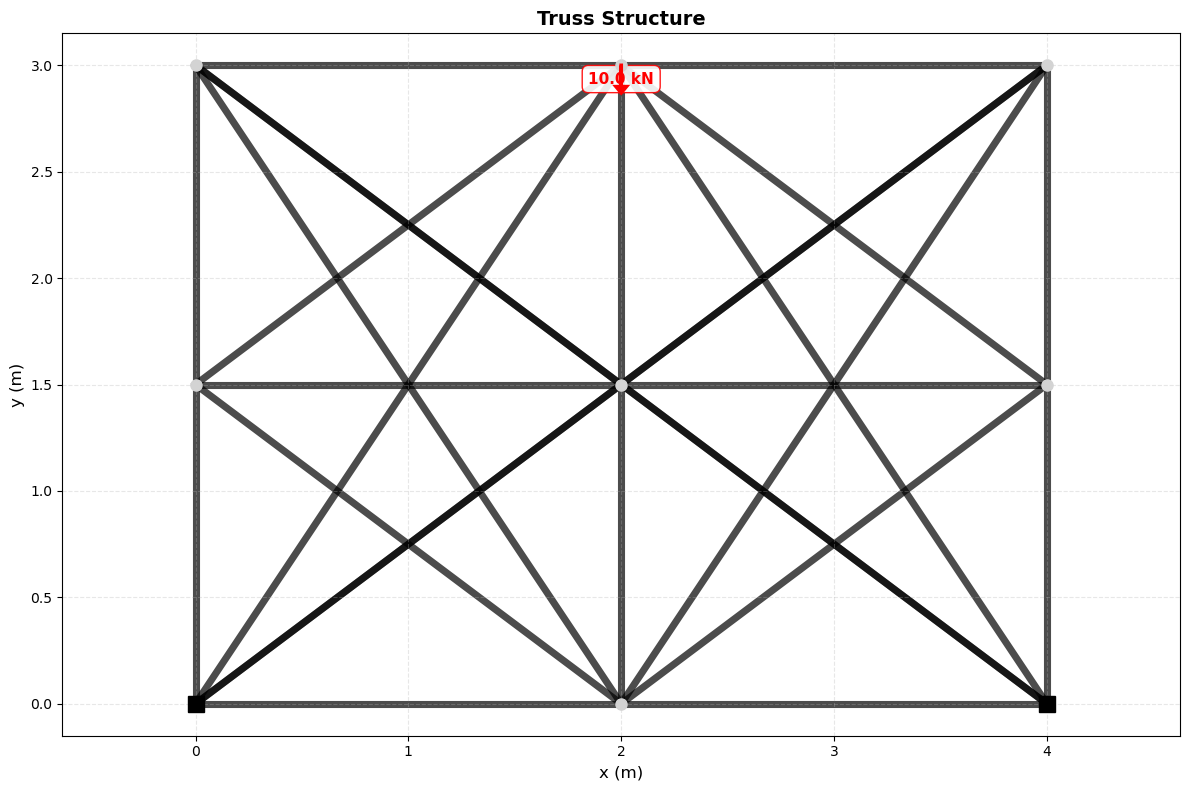

  Volume: 0.0327 m^3
  Max displacement: 0.0001136 m
  Max stress: 7.28e+06 Pa
  Compliance: 1.14 J


In [9]:
fem_model = truss3x3()
fem_model.plot_truss()
fem_model.solve()
metrics = fem_model.evaluate_design()
V0 = metrics['volume']
fem_model.print_metrics(metrics)



## QA Truss Optimization

QUANTUM ANNEALING TOPOLOGY OPTIMIZATION
Problem: 26 elements
Target volume: 0.0082 m³
Initial areas: [0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005
 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005
 0.0005 0.0005 0.0005 0.0005 0.0005 0.0005]

OPTIMIZATION COMPLETE
Total iterations: 50
Total time: 20.72s (0.414s per iteration)

Final Design:
  Compliance: 1.3763e+00 J
  Volume: 0.0082 m³ (target: 0.0082)
  Active members: 5/26
  Area range: [2.5769e-06, 7.1007e-04] m²


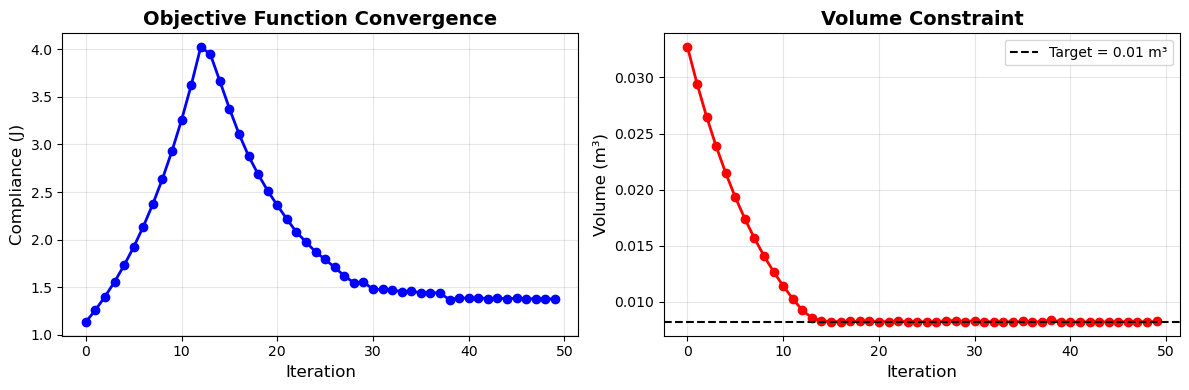

In [10]:
trussQA = QATrussOptimizer(
        fem_model=fem_model,
        V_bar= 0.25*V0, 
    )

# Run optimization
results = trussQA.optimize()

trussQA.plot_convergence()

## Optimized truss

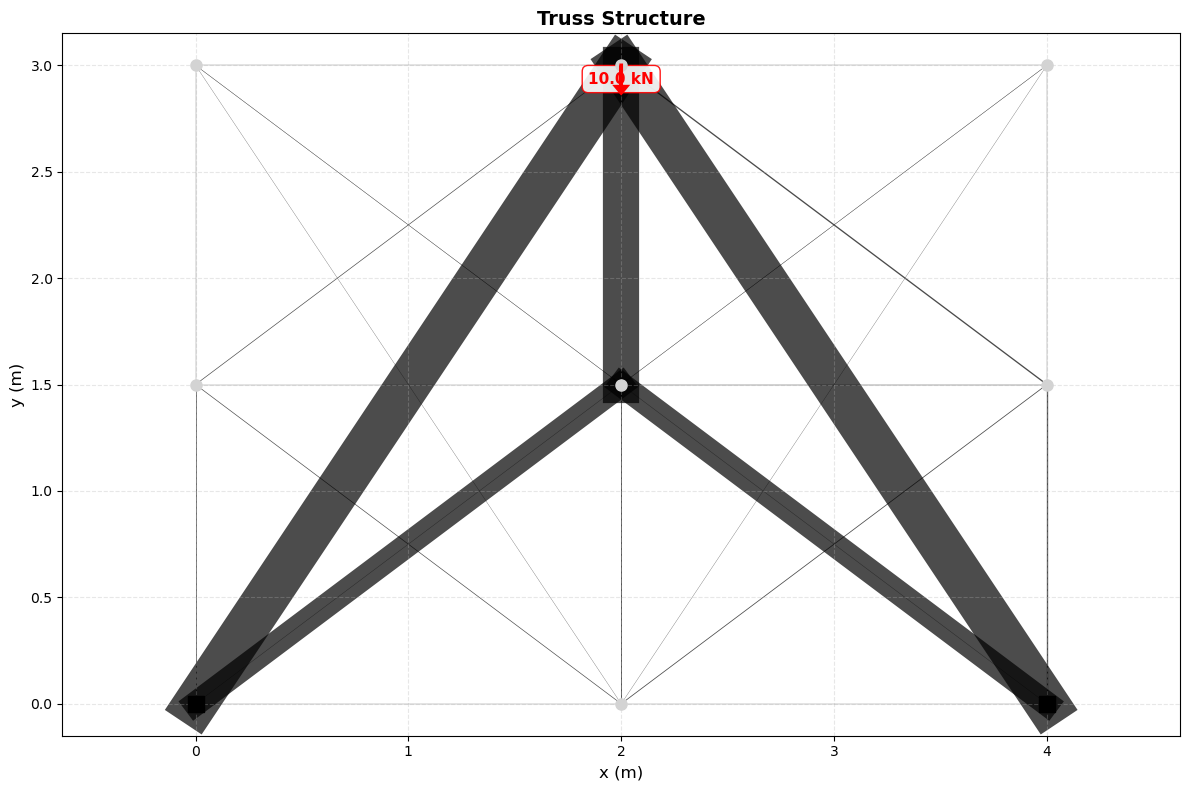

In [11]:
fem_model.plot_truss()